# Transient Universe: MCMC Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
import corner

#Nice figures
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [2]:
data = np.load('../solutions/transient.npy')

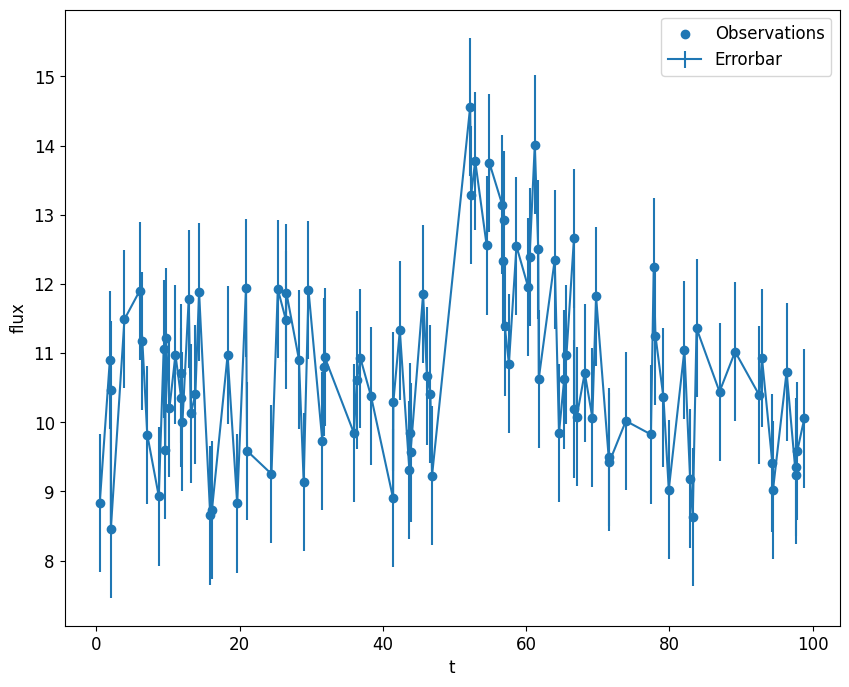

In [3]:
#Faster unpacking!!
t, flux, flux_err = data.T

#Plotting with errors
plt.scatter(t, flux, label='Observations')
plt.errorbar(t, flux, yerr=flux_err, label='Errorbar')
plt.xlabel('t')
plt.ylabel('flux')
plt.legend()
plt.show()

Burst model approximation in which signal is:

$y = b$ if  $t < t_{0}$

$y = b + A\cdot \exp[-\alpha(t-t_{0}])$ if  $t \geq t_{0}$

In [4]:
#Function modeling Signal: Noise + Exponential decay
def fun_model(parameters, t):

    b, t_0, A, alpha = parameters.T

    return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))

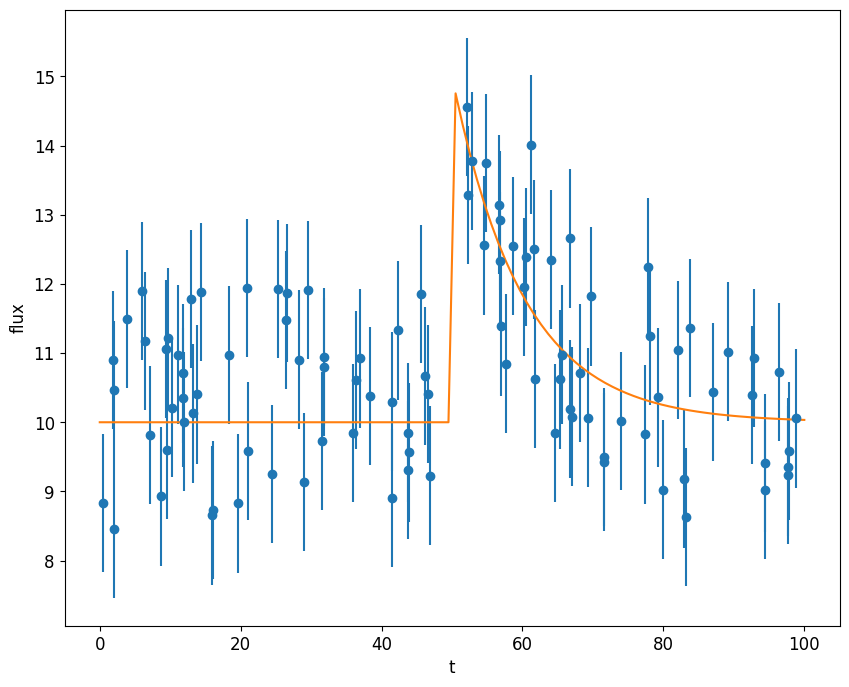

In [5]:
#Eyeball estimate
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1

theta_quick= np.array([b_quick, t0_quick, A_quick, alpha_quick])

#Evaluating the function
ygrid = fun_model(theta_quick, tgrid)

plt.errorbar(t, flux ,yerr=flux_err, fmt='o')
plt.xlabel("t")
plt.ylabel("flux")
plt.plot(tgrid, ygrid);

## EMCEE

In [6]:
def loglike(theta, data, model):
    t, flux, flux_err = data.T

    #Computing theoretical flux
    flux_th = model(theta, t)
    
    #Gaussian Log-Likelihood -> Distance from theoretical value
    logL = -0.5 * np.sum(((flux - flux_th)**2 / (flux_err)**2))

    return logL

def logprior(theta):
    #Priors initialization
    t0min, t0max = 0, 100
    Amin, Amax = 0, 50
    bmin, bmax = 0, 50
    alphamin, alphamax = np.exp(-5), np.exp(5)


    A, b, t0, alpha = theta

    if (Amin < A < Amax) and (bmin < b < bmax) and (t0min < t0 < t0max) and (alphamin < alpha < alphamax):
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf

def logposterior(theta, data, model):
    return loglike(theta, data, model) + logprior(theta)

In [7]:
#Number of free parameters
ndim = 4

#Sampler walkers 
nwalkers = 5 * ndim

#Steps that each walker takes -> Number of samples per walker
steps = 10000

#Initial Guess on A, b, t0, alpha
theta_guess = np.array([10.0, 50.0,  6.5,  0.2])
initial_guess = theta_guess + 1e-1* np.random.randn(nwalkers, ndim)

In [8]:
#Sampler setup
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[data, fun_model])

#Sampling
sampler.run_mcmc(initial_guess, steps);

/Users/oliverbenjaminrossi/Visual Studio/Università/.venv/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


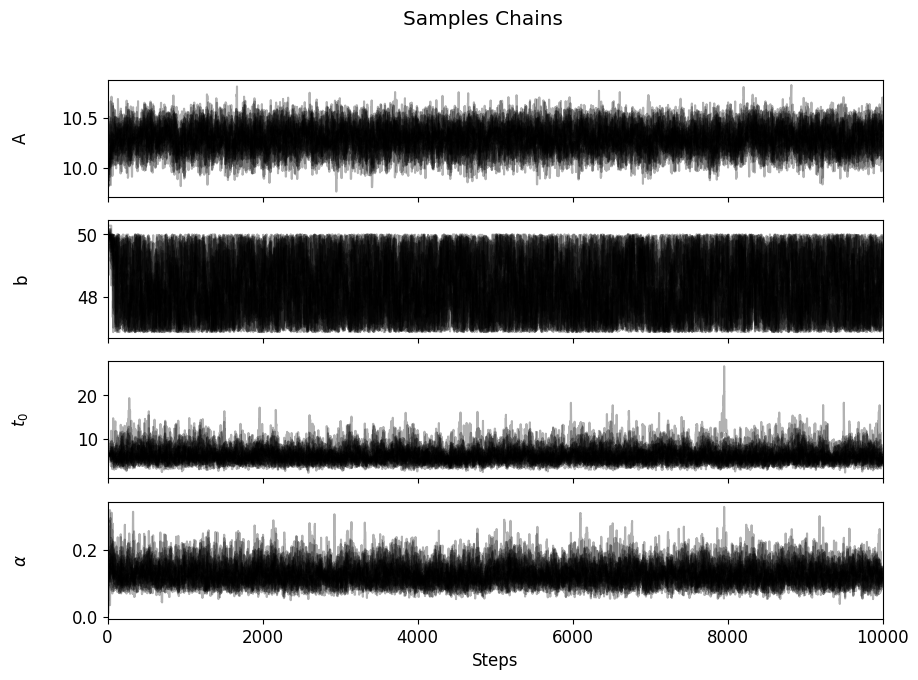

In [9]:
#Gather chains
samples = sampler.get_chain()

#Plotting chains
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ['A', 'b', '$t_{0}$', '$\\alpha$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c='k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig.suptitle('Samples Chains')
axes[-1].set_xlabel('Steps');

In [10]:
#Autocorrelation time of the chain
tau = sampler.get_autocorr_time()
print('For chains\n{}\nAutocorrelation time tau is\n{}'.format(labels, tau))

For chains
['A', 'b', '$t_{0}$', '$\\alpha$']
Autocorrelation time tau is
[66.31438338 68.11801755 70.08550649 69.23084107]


In [11]:
#Manipulating samples by burning the first [tau] part of the chain and thinning each [tau]
#Flat=True squishes each chain constructed by the walkers into a single chain for ndim = 4 free parameters
thinned_samples = sampler.get_chain(discard=int(max(tau)), thin=int(max(tau)), flat=True)
thinned_samples.shape

#Performing a quick analysis of the samples with median and quantiles

theta_median, quantile = [], []

for i in range(4):
    theta_median.append(np.median(thinned_samples[:, i]))
    quantile.append(np.quantile(thinned_samples[:, i], q=[0.10, 0.90]))

theta_median = np.array(theta_median)
quantile = np.array(quantile)

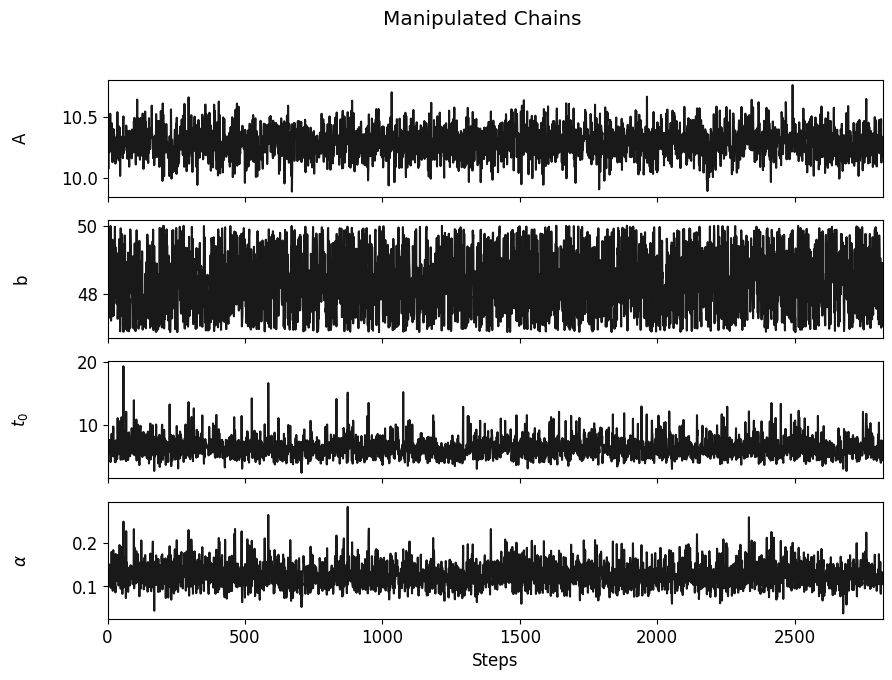

In [12]:
#Plotting manipulated chains to visualize the effects
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(thinned_samples[:, i], c='k', alpha=0.9)
    ax.set_xlim(0, len(thinned_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig.suptitle('Manipulated Chains')
axes[-1].set_xlabel('Steps');

In [13]:
np.save('MCMC_chains', thinned_samples)

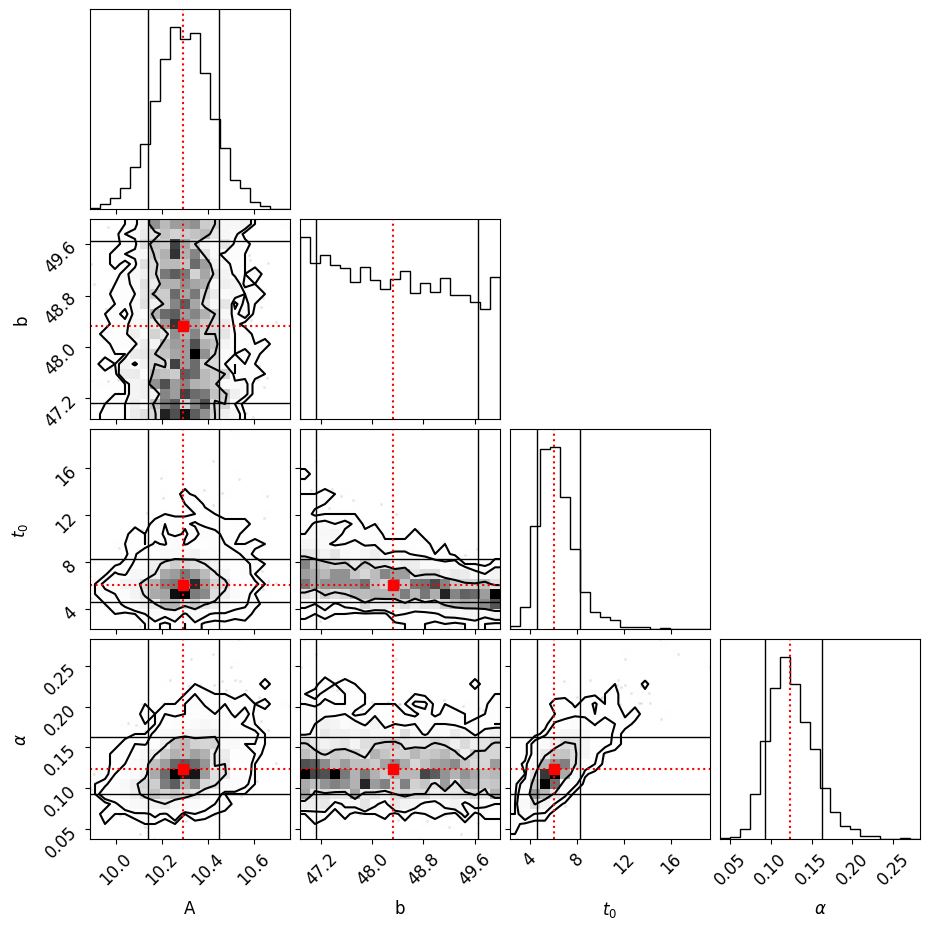

In [14]:
#Contours at 68%, 95% and 99% probability
levels = [0.68, 0.95, 0.99]

#Corner Plot
cornerplot = corner.corner(thinned_samples, labels=labels, levels=levels)

#Overplotting median values
corner.overplot_lines(cornerplot, theta_median, color='red', ls=':')
corner.overplot_points(cornerplot, theta_median[None], marker='s', markersize=7, color='red')

#Overplotting 90% C.I.
corner.overplot_lines(cornerplot, quantile[:, 0], color='black', linewidth=1)   #Left limit 
corner.overplot_lines(cornerplot, quantile[:, 1], color='black', linewidth=1)   #Right limit

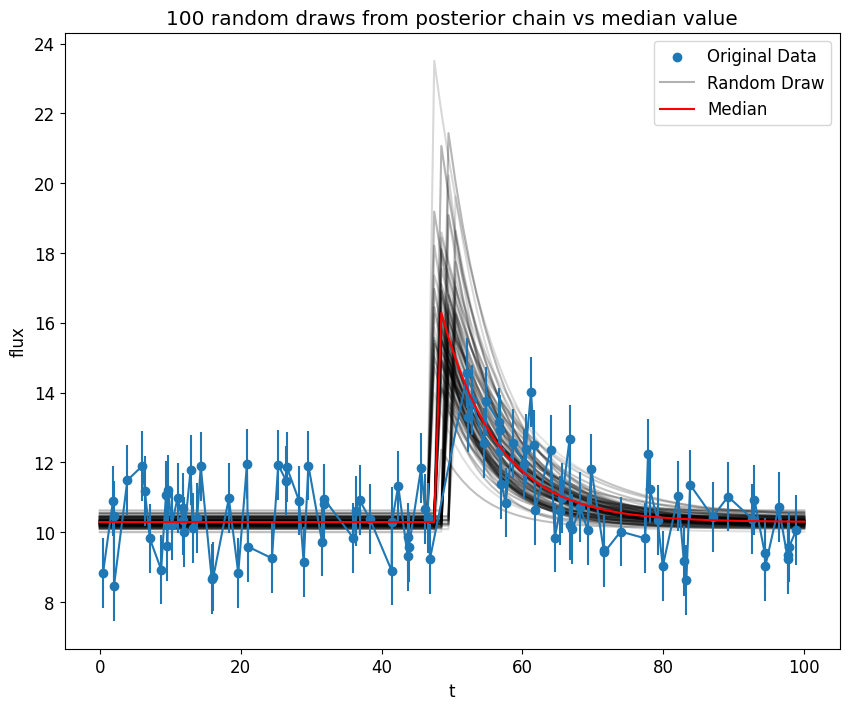

In [15]:
#Showing 100 random samples from posterior chains vs Median values
tgrid=np.linspace(0,100,100)
new_theta = []
draws = 100

for i in range(ndim):
    new_theta.append(np.random.choice(thinned_samples[:, i], draws))

new_theta = np.array(new_theta)

#Plotting
plt.scatter(t, flux, zorder=1, label='Original Data')
plt.errorbar(t, flux, yerr=flux_err, zorder=0)

plt.plot(tgrid, fun_model(new_theta[:, 0], tgrid), c='k', alpha=0.3, zorder=-1, label='Random Draw')

opacity = np.linspace(0.1, 0.3, 100)
for i, j in zip(range(1, 100), opacity):
    plt.plot(tgrid, fun_model(new_theta[:, i], tgrid), c='k', alpha=j, zorder=-1)

plt.plot(tgrid, fun_model(theta_median, tgrid), c='red', zorder=2, label='Median')
plt.xlabel('t')
plt.ylabel('flux')
plt.title('{} random draws from posterior chain vs median value'.format(draws))
plt.legend()
plt.show()

### Final results

In [16]:
#For convenience I instantiate a class for printing subtitles and suptitles
from IPython.display import Math

class subsup:
    def __init__(self,label, base, subtitle, suptitle):
        self.label = label
        self.base = base
        self.sub = subtitle
        self.sup = suptitle
    

    def  _ipython_display_(self):
        disp_base = str(round(self.base, 3))
        disp_sub = '-' + str(round(self.sub, 3))
        disp_sup = '+' + str(round(self.sup, 3))
        label = self.label

        display(Math(f"{label}: {{{disp_base}}}^{{{disp_sup}}}_{{{disp_sub}}}"))

#Reformatting labels
new_labels = ['A', 'b', 't_{0}', '\\alpha']

#Printing final results
print('Final Results:')
for i, ii in enumerate(labels):
    value = theta_median[i]
    value_right = np.abs(value - quantile[i, 1])
    value_left = np.abs(value - quantile[i, 0])

    result = subsup(label= new_labels[i], base=value, subtitle=value_left, suptitle=value_right)
    result._ipython_display_()

Final Results:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>